# Agent Learning Project

## Imports 

In [1]:
import numpy as np # Useful for computations and probabilistic distributions
import matplotlib.pyplot as plt # Plotting Graph for Simulation results
import statistics # Useful to get statistics at the end of the Simulation
import tkinter as tk # Graphical Interface library 
from collections import defaultdict # Specific kind of dictionary that avoids KeyErrors

## Defining the Agent class

In [2]:
class Agent:
    def __init__(self, agent_type, service_prob, reward):
        self.agent_type = agent_type
        self.service_prob = service_prob
        self.reward = reward
        self.time_in_queue = 0

    def __str__(self):
        return f"Agent {self.agent_type} ({self.time_in_queue})"

## Defining the Queue mechanism 

In [3]:
class QueueSimulation:
    def __init__(
        self,
        num_agent_types,
        service_probs,
        rewards,
        arrival_prob,
        type_distribution,
        k=4,
        sim_mode="manual",
        strategy=None,
        lambda_param=1.0
    ):
        self.num_agent_types = num_agent_types
        self.service_probs = service_probs
        self.rewards = rewards
        self.arrival_prob = arrival_prob
        self.type_distribution = type_distribution
        self.k = k
        self.sim_mode = sim_mode
        self.strategy = strategy
        self.lambda_param = lambda_param
        self.queue = [self.create_agent() for _ in range(k)]
        self.current_agent = None
        self.time = 0
        self.total_reward = 0
        self.serviced_agents = defaultdict(int)
        self.reward_history = []
        self.queue_length_history = []
        self.length = len(self.queue)

    def create_agent(self):
        agent_type = np.random.choice(
            range(self.num_agent_types), p=self.type_distribution
        )
        return Agent(
            agent_type, self.service_probs[agent_type], self.rewards[agent_type]
        )

    def step(self):
        # Check if the current agent is done being served
        if self.current_agent:
            if np.random.rand() < self.current_agent.service_prob:
                self.total_reward += self.current_agent.reward
                self.serviced_agents[self.current_agent.agent_type] += 1
                self.current_agent = None

        # Increment time_in_queue for all agents in the queue
        for agent in self.queue:
            agent.time_in_queue += 1

        # Add new agent to the queue based on arrival probability
        if np.random.rand() < self.arrival_prob:
            new_agent = self.create_agent()
            self.queue.append(new_agent)

        self.time += 1

        # Add a penalty which is proportional to the queue length
        self.total_reward += penalty(self.lambda_param,self.length)

        # Apply the strategy to select the next agent
        if self.sim_mode == "automatic" and self.queue:
            if self.strategy:
                queue_index = self.strategy(self.queue)
                self.swap_agents(queue_index)

        # Record history
        self.reward_history.append(self.total_reward)
        self.queue_length_history.append(len(self.queue))
        self.length = len(self.queue)

    def get_queue_status(self):
        self.length = len(self.queue)
        return [str(agent) for agent in self.queue]

    def get_current_agent(self):
        return str(self.current_agent) if self.current_agent else "None"

    def get_total_reward(self):
        return self.total_reward

    def swap_agents(self, queue_index):
        if 0 <= queue_index < len(self.queue):
            if self.current_agent:
                self.queue[queue_index], self.current_agent = (
                    self.current_agent,
                    self.queue[queue_index],
                )
            else:
                self.current_agent = self.queue.pop(queue_index)

    def run_simulation(self, steps=1000):
        for _ in range(steps):
            self.step()

    def plot_results(self):
        # Plot total reward over time
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.plot(self.reward_history)
        plt.title('Total Reward over Time')
        plt.xlabel('Time')
        plt.ylabel('Total Reward')

        # Plot queue length over time
        plt.subplot(1, 3, 2)
        plt.plot(self.queue_length_history)
        plt.title('Queue Length over Time')
        plt.xlabel('Time')
        plt.ylabel('Queue Length')

        # Plot distribution of serviced agents by type
        plt.subplot(1, 3, 3)
        agent_types, counts = zip(*sorted(self.serviced_agents.items()))
        plt.bar(agent_types, counts)
        plt.title('Distribution of Serviced Agents by Type')
        plt.xlabel('Agent Type')
        plt.ylabel('Count')

        plt.tight_layout()
        plt.show()


## Designing our Graphical User Interface

In [4]:
class QueueSimulationGUI:
    def __init__(self, master, simulation):
        self.master = master
        self.simulation = simulation
        self.master.title("Queue Simulation")

        # Frame for displaying the time
        self.time_frame = tk.Frame(master)
        self.time_frame.pack(pady=10)

        self.time_label = tk.Label(
            self.time_frame, text="Time: 0", font=("Helvetica", 14)
        )
        self.time_label.pack()

        # Frame for displaying the queue
        self.queue_frame = tk.Frame(master)
        self.queue_frame.pack(pady=10)

        self.queue_label = tk.Label(
            self.queue_frame,
            text=f"Queue - Length: {self.simulation.length}",
            font=("Helvetica", 14),
        )
        self.queue_label.pack()

        self.queue_canvas = tk.Canvas(
            self.queue_frame, width=600, height=150, bg="white"
        )
        self.queue_canvas.pack()

        # Frame for displaying the current agent at the counter
        self.counter_frame = tk.Frame(master)
        self.counter_frame.pack(pady=10)

        self.counter_label = tk.Label(
            self.counter_frame, text="Counter", font=("Helvetica", 14)
        )
        self.counter_label.pack()

        self.counter_canvas = tk.Canvas(
            self.counter_frame, width=200, height=100, bg="white"
        )
        self.counter_canvas.pack()

        # Frame for displaying the total reward
        self.reward_frame = tk.Frame(master)
        self.reward_frame.pack(pady=10)

        self.reward_label = tk.Label(
            self.reward_frame, text="Total Reward: 0", font=("Helvetica", 14)
        )
        self.reward_label.pack()

        # Frame for action buttons
        self.action_frame = tk.Frame(master)
        self.action_frame.pack(pady=10)

        self.next_step_button = tk.Button(
            self.action_frame, text="Next Step", command=self.next_step
        )
        self.next_step_button.pack(side=tk.LEFT, padx=10)

        self.reset_button = tk.Button(
            self.action_frame, text="Reset", command=self.reset_simulation
        )
        self.reset_button.pack(side=tk.LEFT, padx=10)

        # Frame for input and switch button
        self.input_frame = tk.Frame(master)
        self.input_frame.pack(pady=10)

        self.index_label = tk.Label(
            self.input_frame, text="Enter Queue Index:", font=("Helvetica", 14)
        )
        self.index_label.pack(side=tk.LEFT)

        self.index_entry = tk.Entry(self.input_frame, width=5)
        self.index_entry.pack(side=tk.LEFT, padx=5)

        self.switch_button = tk.Button(
            self.input_frame, text="Switch", command=self.switch_agent
        )
        self.switch_button.pack(side=tk.LEFT, padx=10)

        self.reset_simulation()

    def next_step(self):
        self.simulation.step()
        self.update_labels()

    def switch_agent(self):
        try:
            agent_index = int(self.index_entry.get())
            self.simulation.swap_agents(agent_index)
            self.update_labels()
        except Exception:
            pass  # We could imagine adding an error message here

    def update_labels(self):
        self.time_label.config(text=f"Time: {self.simulation.time}")
        self.reward_label.config(
            text=f"Total Reward: {self.simulation.get_total_reward()}"
        )
        self.queue_label.config(
            text=f"Queue - Length: {self.simulation.length}",
        )

        # Update queue visualization
        self.queue_canvas.delete("all")
        for idx, agent in enumerate(self.simulation.queue):
            self.queue_canvas.create_rectangle(
                10 + 110 * idx, 10, 100 + 110 * idx, 60, fill="lightblue"
            )
            self.queue_canvas.create_text(55 + 110 * idx, 35, text=str(agent))

        # Update counter visualization
        self.counter_canvas.delete("all")
        if self.simulation.current_agent:
            self.counter_canvas.create_rectangle(50, 10, 150, 60, fill="lightgreen")
            self.counter_canvas.create_text(
                100, 35, text=str(self.simulation.current_agent.agent_type)
            )
        else:
            self.counter_canvas.create_text(100, 35, text="Empty")

    def reset_simulation(self):
        self.simulation = QueueSimulation(
            self.simulation.num_agent_types,
            self.simulation.service_probs,
            self.simulation.rewards,
            self.simulation.arrival_prob,
            self.simulation.type_distribution,
            self.simulation.k,
            self.simulation.sim_mode,
            self.simulation.strategy,
            self.simulation.lambda_param  # Pass the lambda parameter
        )
        self.update_labels()

## Choosing base parameters

In [5]:
# Number of agent types
num_agent_types = 6

# Service probabilities for each type
service_probs = [
    0.7, # service probability for Agents of type 1
    0.5, # service probability for Agents of type 2
    0.3, # service probability for Agents of type 3
    0.4, # ...
    0.8,
    0.5,
]

# Rewards for each type
# Can be uniform if we want to maximise speed of service
rewards = [
    10.0, 
    20.0, 
    30.0, 
    20.0, 
    4.0, 
    50.0,
] 

# Probabilty that a new agent joins the queue
# I chose this because it is the expected value of someone being serviced at every turn
# With this value, we should therefore get, on average, 1 person in for 1 person out
arrival_prob = 0.5

# If someone joins the queue, distribution of agent types
type_distribution = [
    0.3,
    0.15,
    0.2,
    0.1,
    0.2,
    0.05,
]

# Number of agents in the queue at t = 0
nb_agents_in_queue = 5

# Penalty coefficient and function for the length of the queue
lambda_param = 0.1
def penalty(lambda_param,length):
    return -lambda_param*length

## Defining strategies

In [6]:
# Strategy n°1
def priority_list_strategy(queue, priority_list):
    return min(range(len(queue)), key=lambda i: priority_list.index(queue[i].agent_type))

# Strategy n°2
def first_in_first_served(queue):
    return 0

# Strategy n°3
def dynamic_strategy(queue):
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue)

# Strategy n°4: Shortest Service Time First
def shortest_service_time_first(queue):
    return min(range(len(queue)), key=lambda i: queue[i].service_prob)

# Strategy n°5: Highest Reward First
def highest_reward_first(queue):
    return max(range(len(queue)), key=lambda i: queue[i].reward)

# Strategy n°6: Longest Queue Time with Reward Consideration
def longest_queue_time_reward(queue):
    return max(range(len(queue)), key=lambda i: (queue[i].time_in_queue * queue[i].reward))

# Strategy n°7: Round Robin
round_robin_counter = 0
def round_robin(queue):
    global round_robin_counter
    index = round_robin_counter % len(queue)
    round_robin_counter += 1
    return index

# Strategy n°8: Random Selection
def random_selection(queue):
    return np.random.randint(len(queue))

# Strategy n°9: Least Recently Used
used_agents = []
def least_recently_used(queue):
    global used_agents
    for i, agent in enumerate(queue):
        if agent not in used_agents:
            used_agents.append(agent)
            if len(used_agents) > 10:
                used_agents.pop(0)
            return i
    return 0  # fallback

# Strategy n°10: Least Reward per Service Time
def least_reward_per_service_time(queue):
    return min(range(len(queue)), key=lambda i: queue[i].reward / queue[i].service_prob)

# Strategy n°11: Priority with Dynamic Adjustment
def dynamic_priority_adjustment(queue):
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue + queue[i].reward)

# Strategy n°12: Highest Reward per Waiting Time
def highest_reward_per_waiting_time(queue):
    return max(range(len(queue)), key=lambda i: queue[i].reward / (queue[i].time_in_queue + 1))

# Strategy n°13: Longest Waiting Time with Penalty for High Reward
def longest_waiting_with_penalty(queue):
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue - 0.1 * queue[i].reward)

# Strategy n°14: Reward with Service Probability Consideration
def reward_service_prob_adjustment(queue):
    return max(range(len(queue)), key=lambda i: queue[i].reward * queue[i].service_prob)

# Strategy n°15: Weighted Random Selection
def weighted_random_selection(queue):
    weights = [agent.time_in_queue + agent.reward for agent in queue]
    total_weight = sum(weights)
    probabilities = [weight / total_weight for weight in weights]
    return np.random.choice(range(len(queue)), p=probabilities)

# Strategy n°16: Combined Priority and Waiting Time
def combined_priority_waiting(queue, priority_list):
    return max(range(len(queue)), key=lambda i: queue[i].time_in_queue * priority_list.index(queue[i].agent_type))


### Explanations of strategies

- **priority_list_strategy**: Selects agents based on a predefined priority list.
- **first_in_first_served**: Selects the first agent in the queue.
- **dynamic_strategy**: Selects the agent who has been waiting the longest.
- **shortest_service_time_first**: Selects the agent with the shortest service time.
- **highest_reward_first**: Selects the agent with the highest reward.
- **longest_queue_time_reward**: Selects the agent with the longest wait time multiplied by reward.
- **round_robin**: Cycles through agents in the queue in a round-robin fashion.
- **random_selection**: Selects an agent randomly from the queue.
- **least_recently_used**: Selects the least recently used agent.
- **least_reward_per_service_time**: Selects the agent with the least reward per unit of service time.
- **dynamic_priority_adjustment**: Selects the agent with the highest combined value of waiting time and reward.
- **highest_reward_per_waiting_time**: Selects the agent with the highest reward per unit of waiting time.
- **longest_waiting_with_penalty**: Selects the agent with the longest wait time, penalizing high rewards.
- **reward_service_prob_adjustment**: Selects the agent with the highest product of reward and service probability.
- **weighted_random_selection**: Selects an agent based on weighted probabilities of their waiting time and reward.
- **combined_priority_waiting**: Selects the agent based on a combination of priority list and waiting time.

The next step could be to implement more complex dynamic strategies and Machine Learning based strategies.

## Choosing a Strategy

Now that we defined multiple strategies, we have to choose one.

In [7]:
# Choose a Strategy Number (can find the list above)
x = 3

# Not very efficient way of proceeding but allows for very specific strategies with plenty of specific parameters
# Should consider changing to make it more readable
if x == 1:
    priority_list = [0, 1, 2, 3, 4, 5]
    strategy = lambda queue: priority_list_strategy(queue, priority_list)
elif x == 2:
    strategy = first_in_first_served
elif x == 3:
    strategy = dynamic_strategy
elif x == 4:
    strategy = shortest_service_time_first
elif x == 5:
    strategy = highest_reward_first
elif x == 6:
    strategy = longest_queue_time_reward
elif x == 7:
    strategy = round_robin
elif x == 8:
    strategy = random_selection
elif x == 9:
    strategy = least_recently_used
elif x == 10:
    strategy = least_reward_per_service_time
elif x == 11:
    strategy = dynamic_priority_adjustment
elif x == 12:
    strategy = highest_reward_per_waiting_time
elif x == 13:
    strategy = longest_waiting_with_penalty
elif x == 14:
    strategy = reward_service_prob_adjustment
elif x == 15:
    strategy = weighted_random_selection
elif x == 16:
    priority_list = [0, 1, 2, 3, 4, 5]
    strategy = lambda queue: combined_priority_waiting(queue, priority_list)
else:
    raise ValueError("Invalid strategy number.")

## Playing the game manually

Execute the main code manually and play the game by making your own decisions through the graphical user interface.

In [8]:
sim_mode = "manual"
should_run = False # Change should_run if you want to play manually

if should_run:
    simulation = QueueSimulation(
        num_agent_types,
        service_probs,
        rewards,
        arrival_prob,
        type_distribution,
        nb_agents_in_queue,
        sim_mode,
        strategy,
        lambda_param,
    )
    root = tk.Tk()
    gui = QueueSimulationGUI(root, simulation)
    root.mainloop()

## Playing the game according to predetermined strategies

Execute the main code automatically by choosing one of the strategies defined above in the 'Define Strategies' section and letting the computer play by itself. This function outputs three graphs. 
- Graph 1: Total reward from time $t_0$ to time $t_{1000}$.
- Graph 2: Length of the Queue from time $t_0$ to time $t_{1000}$.
- Graph 3: Distribution of serviced Agents by type from $t_0$ to time $t_{1000}$.



### Running a specific strategy

Automatic simulation with strategy 'dynamic_strategy'


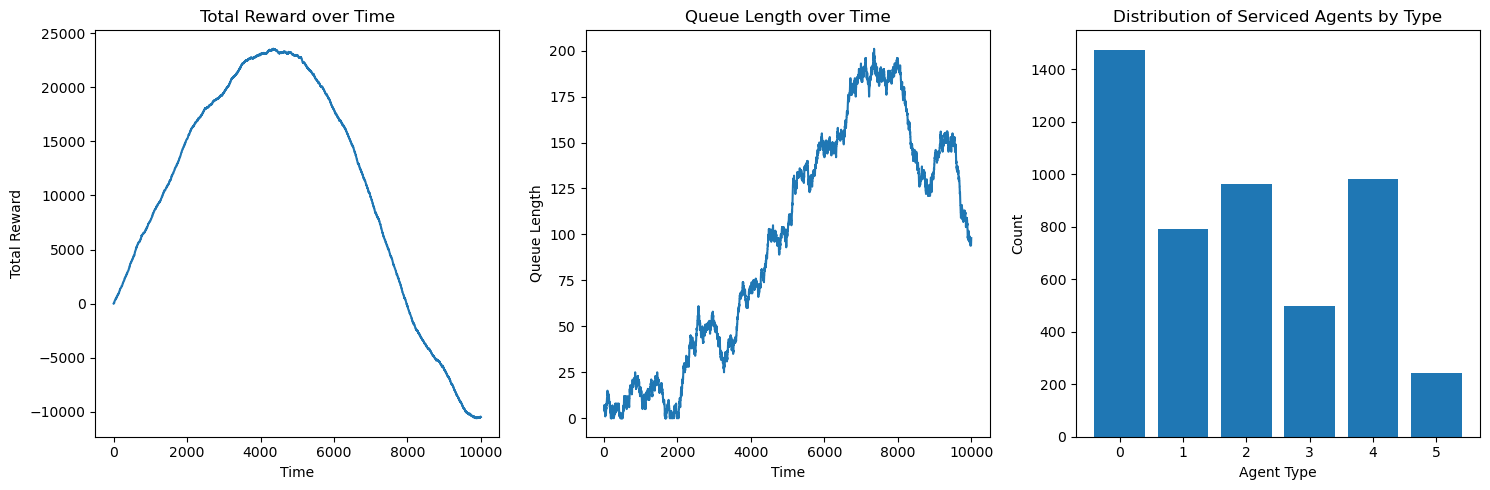

In [9]:
sim_mode = "automatic"

simulation = QueueSimulation(
    num_agent_types,
    service_probs,
    rewards,
    arrival_prob,
    type_distribution,
    nb_agents_in_queue,
    sim_mode,
    strategy,
    lambda_param,
)

print(f"Automatic simulation with strategy '{strategy.__name__}'")
simulation.run_simulation(steps=10000)
simulation.plot_results()

### Comparing strategies

Automatic simulation with strategy '<lambda>'


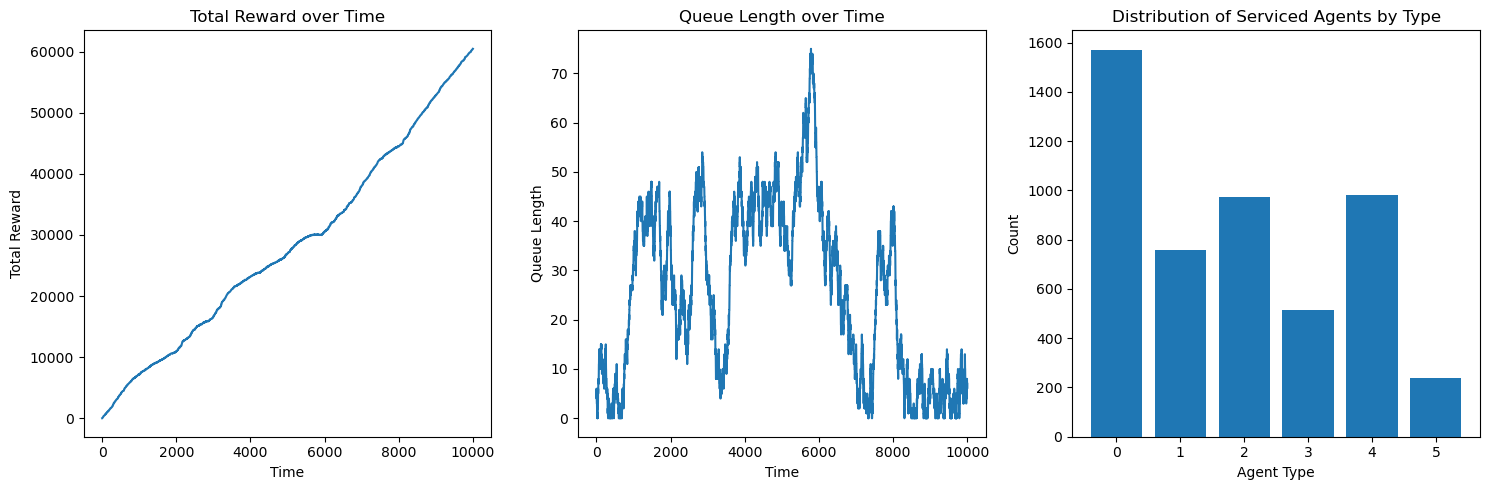

Automatic simulation with strategy 'first_in_first_served'


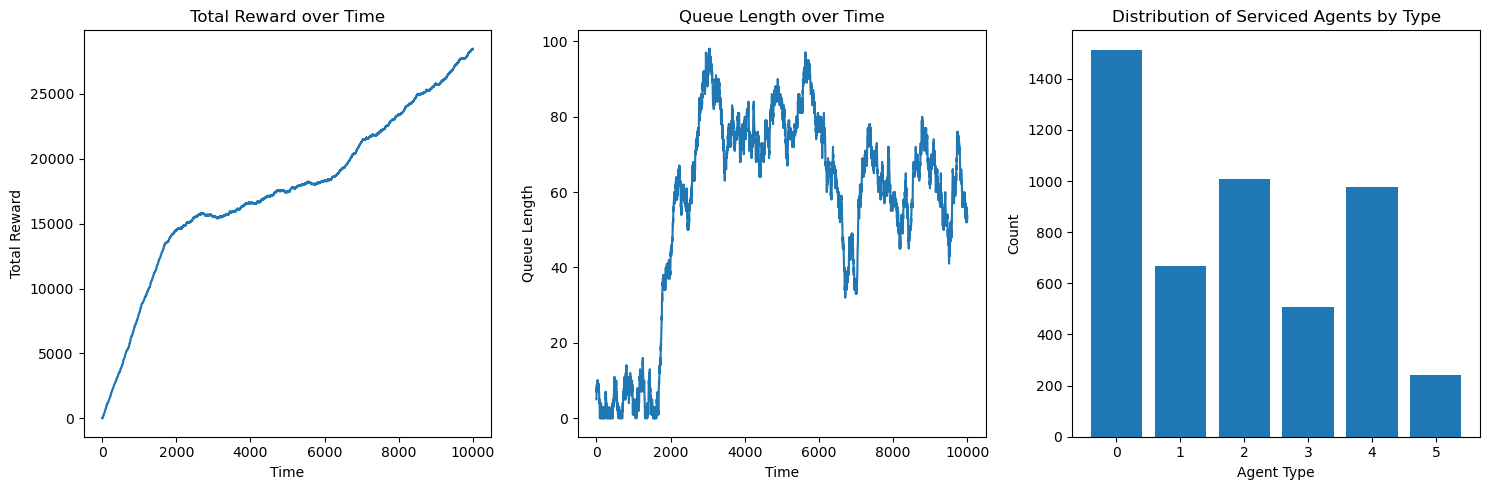

Automatic simulation with strategy 'dynamic_strategy'


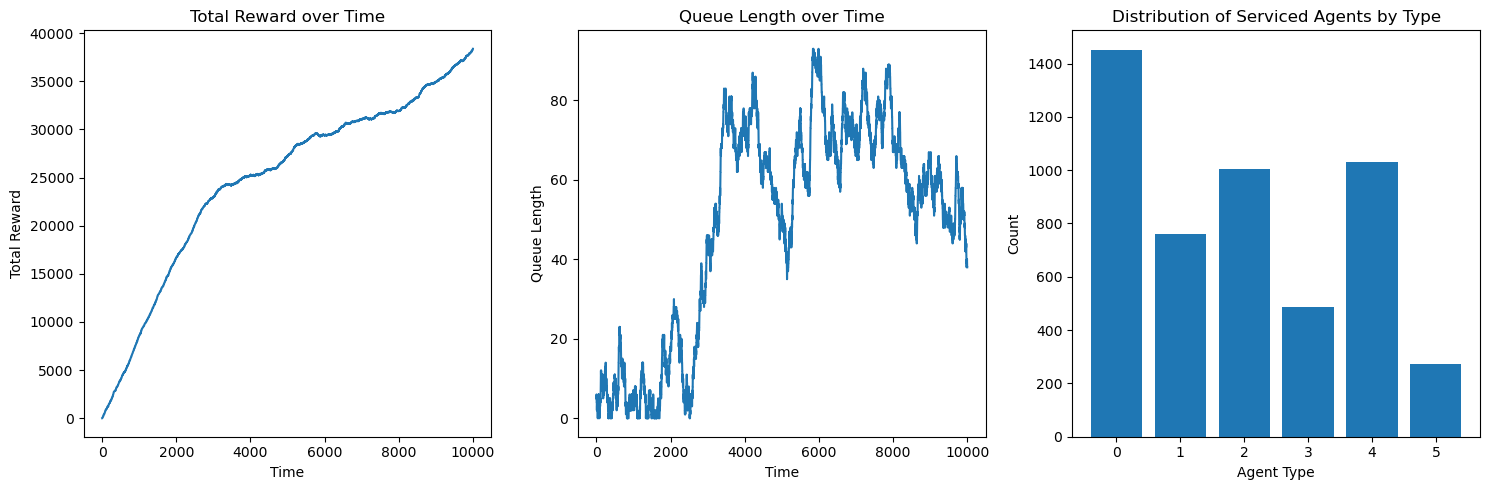

Automatic simulation with strategy 'shortest_service_time_first'


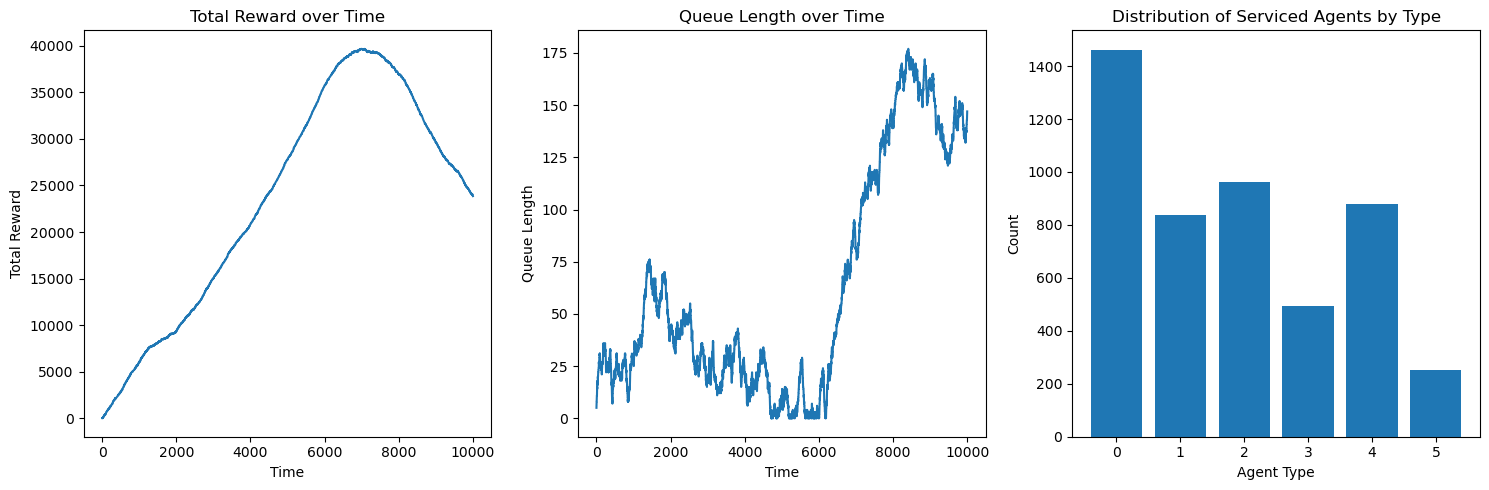

Automatic simulation with strategy 'highest_reward_first'


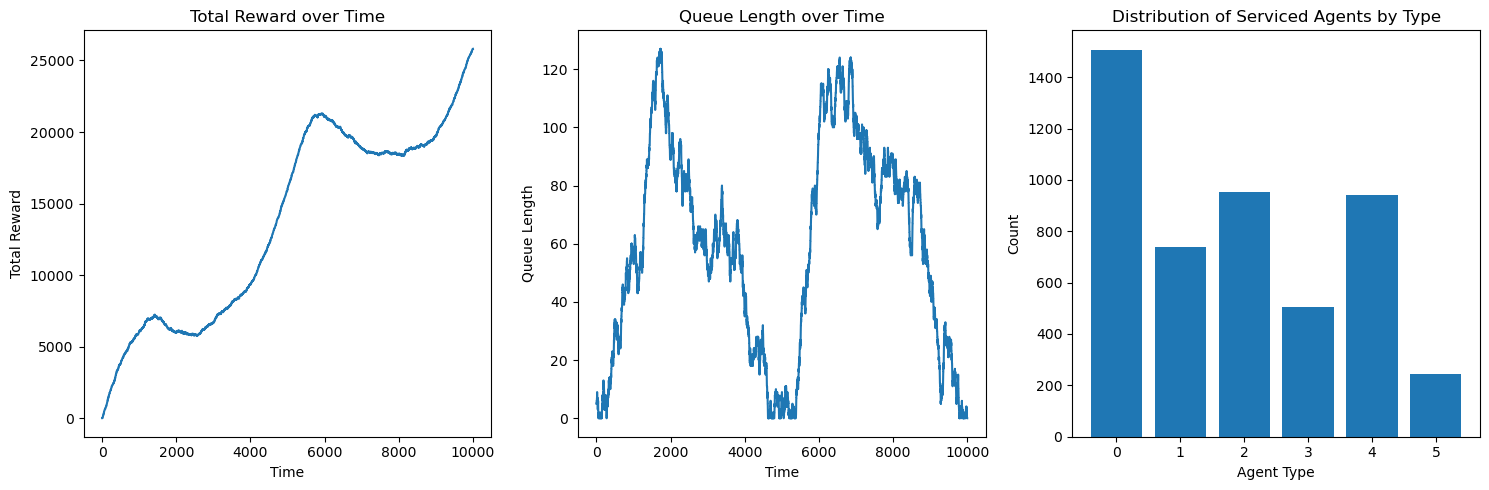

Automatic simulation with strategy 'random_selection'


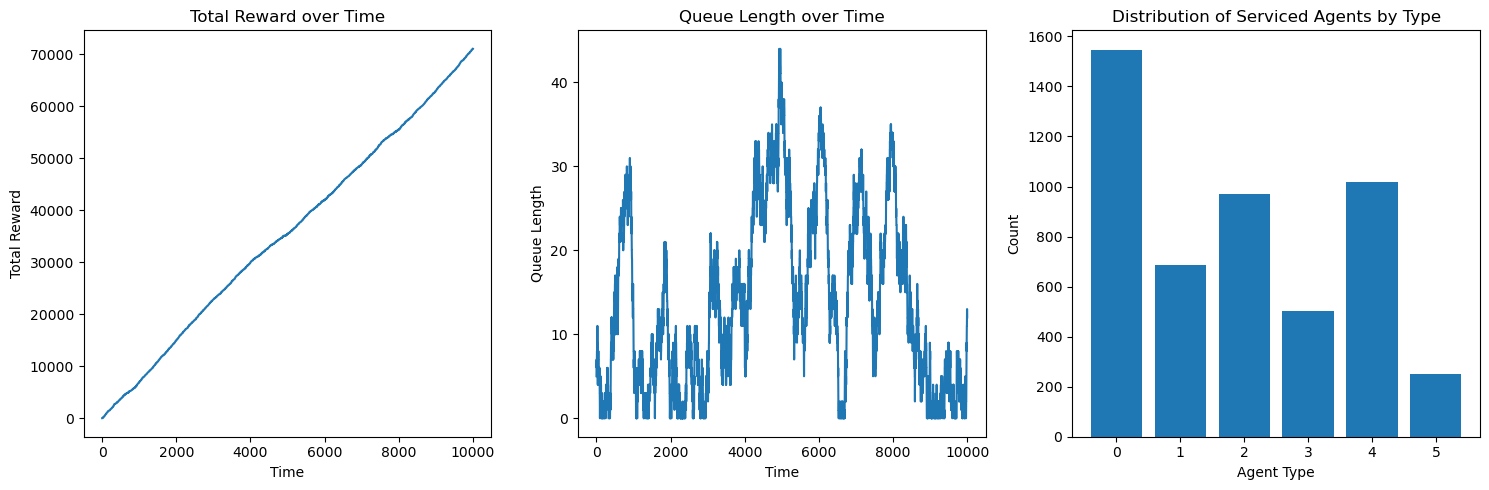

Automatic simulation with strategy 'dynamic_priority_adjustment'


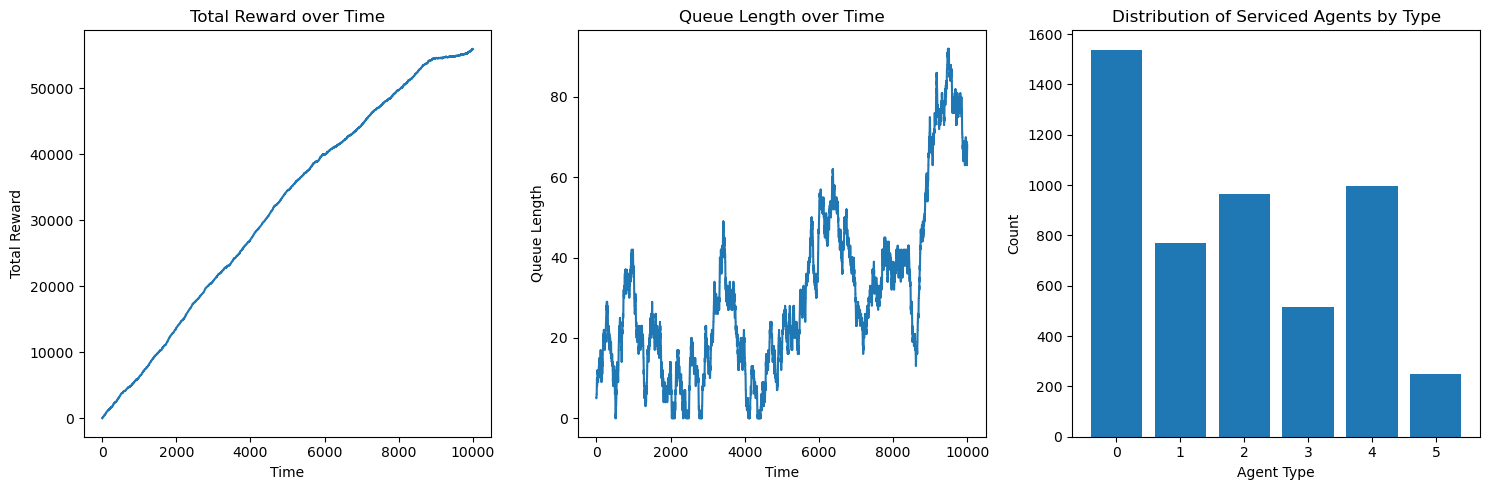

Automatic simulation with strategy 'longest_waiting_with_penalty'


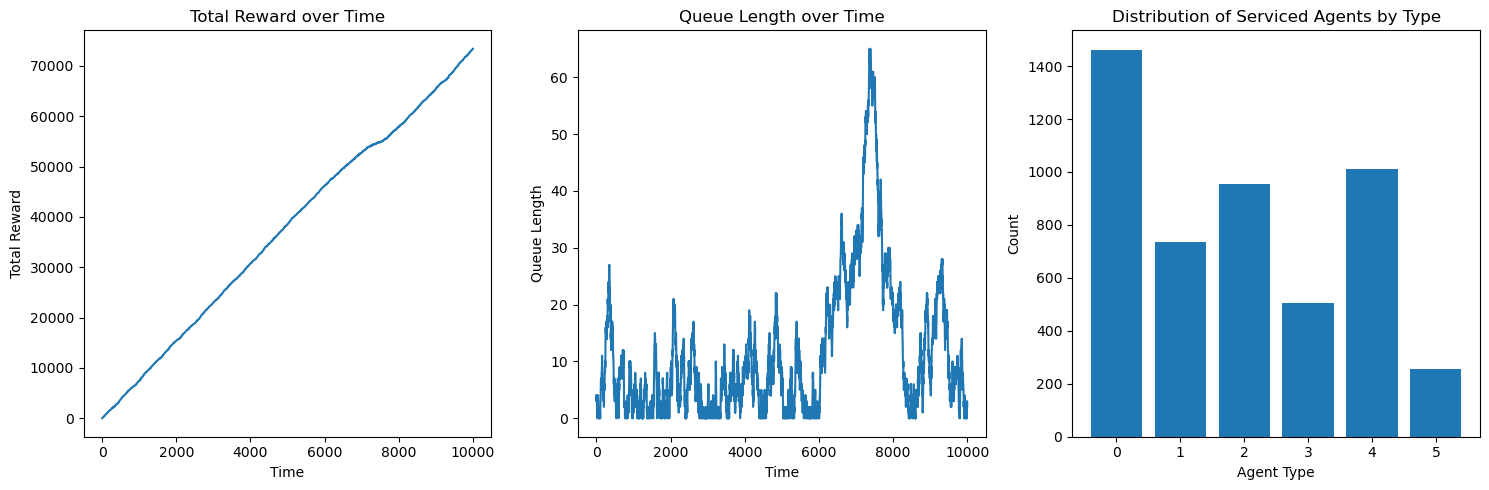

Automatic simulation with strategy 'weighted_random_selection'


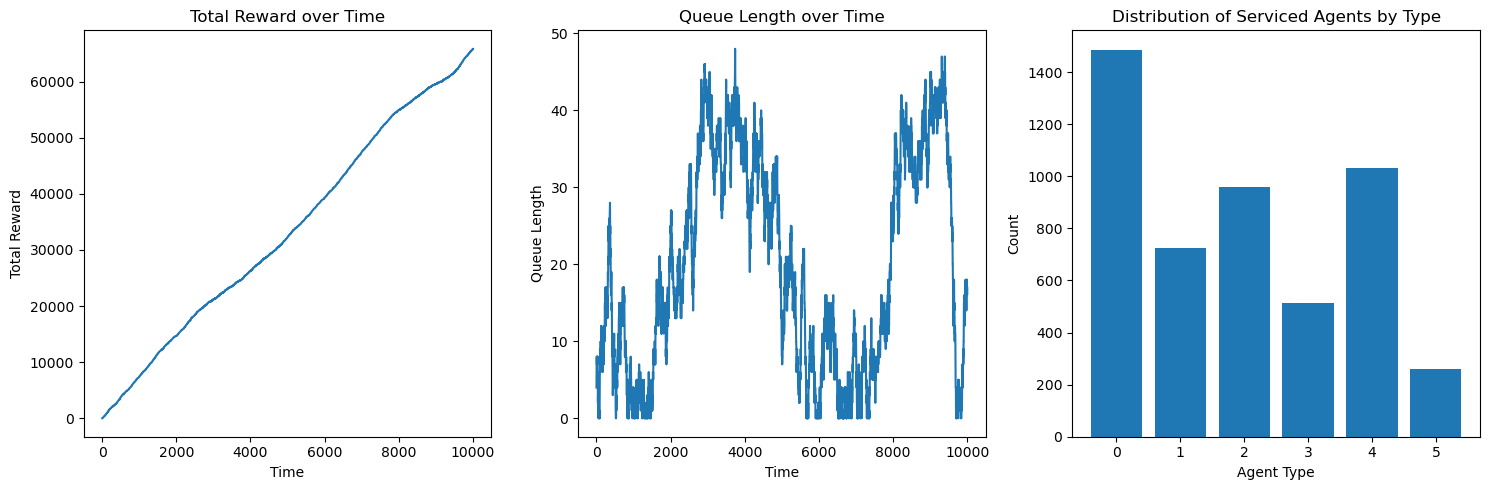

In [10]:
sim_mode = "automatic"

# Initialize a dictionary to store the results
results = {}

for i in [1, 2, 3, 4, 5, 8, 11, 13, 15]: # Write the number of all strategies you want to compare
    # Not very efficient way of proceeding but gets the job done. Should consider changing to make it more readable
    if i == 1:
        priority_list = [0, 1, 2, 3, 4, 5]
        strategy = lambda queue: priority_list_strategy(queue, priority_list)
    elif i == 2:
        strategy = first_in_first_served
    elif i == 3:
        strategy = dynamic_strategy
    elif i == 4:
        strategy = shortest_service_time_first
    elif i == 5:
        strategy = highest_reward_first
    elif i == 6:
        strategy = longest_queue_time_reward
    elif i == 7:
        strategy = round_robin
    elif i == 8:
        strategy = random_selection
    elif i == 9:
        strategy = least_recently_used
    elif i == 10:
        strategy = least_reward_per_service_time
    elif i == 11:
        strategy = dynamic_priority_adjustment
    elif i == 12:
        strategy = highest_reward_per_waiting_time
    elif i == 13:
        strategy = longest_waiting_with_penalty
    elif i == 14:
        strategy = reward_service_prob_adjustment
    elif i == 15:
        strategy = weighted_random_selection
    elif i == 16:
        priority_list = [0, 1, 2, 3, 4, 5]
        strategy = lambda queue: combined_priority_waiting(queue, priority_list)
    else:
        raise ValueError("Invalid strategy number.")
        
    simulation = QueueSimulation(
        num_agent_types,
        service_probs,
        rewards,
        arrival_prob,
        type_distribution,
        nb_agents_in_queue,
        sim_mode,
        strategy,
        lambda_param,
    )

    print(f"Automatic simulation with strategy '{strategy.__name__}'")
    simulation.run_simulation(steps=10000)
    simulation.plot_results()
    
    queue_lengths = simulation.queue_length_history
    total_reward = simulation.get_total_reward()
    agent_distribution = simulation.serviced_agents
    
    results[strategy.__name__] = {
        "total_reward": total_reward,
        "min_queue_length": np.min(queue_lengths),
        "max_queue_length": np.max(queue_lengths),
        "mean_queue_length": np.mean(queue_lengths),
        "median_queue_length": np.median(queue_lengths),
        "mode_queue_length": statistics.mode(queue_lengths),
        "normalized_distribution": {agent_type: round(count / sum(agent_distribution.values()), 3) for agent_type, count in sorted(agent_distribution.items(),key=lambda item: item[1],reverse=True)}
    }

### Statistics

In [11]:
# Find the strategy with the most reward
best_strategy = max(results.items(), key=lambda x: x[1]["total_reward"])


# Print the results
print(f"\nBest Strategy: {best_strategy[0]} with total reward of r = {best_strategy[1]['total_reward']}")
print(f"Min & Max Queue Length: {best_strategy[1]['min_queue_length']} & {best_strategy[1]['max_queue_length']}")
print(f"Mean & Median Queue Length: {best_strategy[1]['mean_queue_length']} & {best_strategy[1]['median_queue_length']}")
print(f"Mode Queue Length: {best_strategy[1]['mode_queue_length']}")
print(f"Normalized Distribution of Serviced Agents: {best_strategy[1]['normalized_distribution']}")


Best Strategy: longest_waiting_with_penalty with total reward of r = 73391.20000000062
Min & Max Queue Length: 0 & 65
Mean & Median Queue Length: 11.4625 & 7.0
Mode Queue Length: 0
Normalized Distribution of Serviced Agents: {0: 0.297, 4: 0.205, 2: 0.194, 1: 0.149, 3: 0.103, 5: 0.052}


# Comments

In case something needs to be changed, please feel free to write something in the cell below and email me about it. 

*blank*